The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting...
Data generated


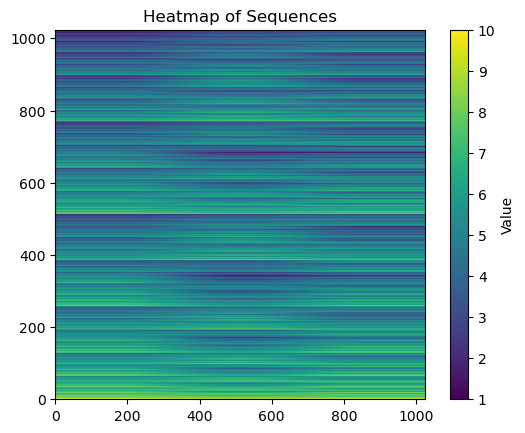

In [19]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes
import itertools
%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D,Wraparound1D,periodic_padding,CustomCallback
from ca_funcs import make_glider, make_game_of_life
import tensorflow as tf
import numpy as np
import random
from train_ca import *
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
def collapse_sequences(sequences):
    collapsed_sequences=[]
    for sequence in sequences:
        for s in sequence:
            collapsed_sequences.append(s.sum())
    return np.array(collapsed_sequences).reshape(-1,sequence_length+1,1)
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
        if logs.get('val_accuracy') == 1:
            self.model.stop_training = True 
#Seedings and Config
 
SEED =3
print("Starting...")
os.environ['PYTHONHASHSEED']=str(SEED)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'  # TF 2.1
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.threading.set_inter_op_parallelism_threads(1)
# 2100 outer totalistic  Generating Data
 
gridsize=10
 
 
x_values = [seq for seq in itertools.product("01", repeat=gridsize)]

x_values = [[int(bit) for bit in seq] for seq in x_values]

MEMORY_CONSTANT=1
num_classes = 2  
sequence_length=MEMORY_CONSTANT*2
 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT)

gol.set_rule([[[0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1]],
               [[0],      [1]         ,[0]      ,[1]     ,[1]      ,[0]      ,[0],     [1 ]]])
#gol.set_rule([[[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]],
 #                 [              [0],       [1],        [0],       [1],       [1],        [0],        [0],        [1]]])


sequences= np.array(gol.generate_training_data_sequences(x_values,sequence_length=sequence_length))

print("Data generated") 

collapsed_sequences=collapse_sequences(sequences)

n = gridsize

plt.imshow(collapsed_sequences, cmap='viridis', origin='upper',
           extent=[0, collapsed_sequences.shape[0], 0,
                   collapsed_sequences.shape[0]], vmin=1, vmax=n,
          )
plt.colorbar(label='Value')
plt.title('Heatmap of Sequences')
#sequences=np.concatenate((sequences,sequences),axis=0)
np.random.shuffle(sequences)
x_sequence=sequences[:,MEMORY_CONSTANT:MEMORY_CONSTANT*2]
y_sequence=sequences[:,MEMORY_CONSTANT*2]
x_sequence.reshape(-1,MEMORY_CONSTANT* gridsize,1)
 
#might leave it unchanged for binary systems    
Y_val_onehot =  tf.squeeze( tf.one_hot(tf.cast( y_sequence.reshape(-1,  gridsize,1), tf.int32), num_classes))
 
x_train = x_sequence
   
y_train= Y_val_onehot
 

 


loss = lambda x, y: tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)),
                                                             tf.reshape(y, shape=(-1, num_classes)),  from_logits=True)
y_train_full= Y_val_onehot


In [20]:
split_ratio = 0.25
print(x_train.shape)

split_point_x = int(len(x_train) * split_ratio)
split_point_y = int(len(y_train_full) * split_ratio)

x_test = x_train[:split_point_x]
y_test = y_train_full[:split_point_y]
x_train = x_train[split_point_x:]
y_train = y_train_full[split_point_y:]


split_point_x = int(len(x_test) * split_ratio)
split_point_y = int(len(y_test) * split_ratio)


x_val = x_test[:split_point_x]
y_val = y_test[:split_point_x]
x_test = x_test[split_point_x:]
y_test = y_test[split_point_x:]


print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


(1024, 1, 10)
x_train shape: (768, 1, 10)
y_train shape: (768, 10, 2)
x_val shape: (64, 1, 10)
y_val shape: (64, 10, 2)
x_test shape: (192, 1, 10)
y_test shape: (192, 10, 2)


# Regular 1D CA learned by a modified versison of the CNN-NIN architecture


In [23]:
memory_horizon=MEMORY_CONSTANT# is equal to 1
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(memory_horizon * gridsize, 1)))  # Reshape input shape
model.add(Wraparound1D(padding=1))
model.add(tf.keras.layers.Conv1D(10, 3, activation='relu', padding='valid',  trainable=True) )

model.add(tf.keras.layers.Conv1D(10, 1, activation='relu', padding='same'))
 
model.add(tf.keras.layers.Dense(units=2, activation="softmax" ,
                                kernel_initializer=tf.keras.initializers.Ones(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss=loss, metrics=['accuracy'])
model.summary()
early_stopping_callback = CustomCallback()
 
x_train_reshaped=x_train.reshape(-1, gridsize,1)
model.fit(x_train_reshaped, y_train, 
          validation_data=(x_val.reshape(-1,gridsize,1 ), y_val)
          ,epochs=100
        , batch_size=1,callbacks=[early_stopping_callback]) 
model.evaluate(x_test.reshape(-1, gridsize,1),y_test)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 wraparound1d_8 (Wraparound1  (None, 12, 1)            0         
 D)                                                              
                                                                 
 conv1d_16 (Conv1D)          (None, 10, 10)            40        
                                                                 
 conv1d_17 (Conv1D)          (None, 10, 10)            110       
                                                                 
 dense_8 (Dense)             (None, 10, 2)             22        
                                                                 
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 0s 1ms/step - loss: 0.3731 - accuracy: 1.0000


[0.3730771541595459, 1.0]

In [78]:
model.predict(x_train[0].reshape(1,10,1))
 


1/1 [==============================] - 0s 91ms/step


array([[[0.00965688, 0.99034303],
        [0.99661976, 0.00338014],
        [0.01609858, 0.9839015 ],
        [0.9925885 , 0.00741141],
        [0.9925885 , 0.00741141],
        [0.9925885 , 0.00741141],
        [0.00965688, 0.99034303],
        [0.99661976, 0.00338014],
        [0.01609858, 0.98390144],
        [0.9925885 , 0.00741141]]], dtype=float32)

In [28]:
x_test=x_test.reshape(1,-1,3,10)
predictions = model.predict(x_test)

final=[]
errors=[]
for grid in predictions:
    for row in grid:
     res=[-1,-1]
     res[np.argmax(row)]=1
     res[np.argmin(row)]=0
     #Only relevant if network does not acchieve 100% accuracy
     if(res[0]==-1 or res[1]==-1):
         res[0]=1
         res[1]=0
         errors.append(row)
     final.append(res)
y_test_reshaped=np.array(y_test).reshape(-1,10,2)
final_pred_reshaped=np.array(final).reshape(-1,10,2)
accuracy = (y_test_reshaped == final_pred_reshaped).mean()
print(f"Test Accuracy: {accuracy} Test-Set Size: {len(x_test)}")
print(f"Errors: {len(errors)}")

ValueError: in user code:

    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\DScie\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_18" is incompatible with the layer: expected shape=(None, 30, 1), found shape=(None, 250, 3, 10)


In [279]:
def most_frequent_state(grids):
    rows, cols = grids[0].shape
    most_frequent = np.zeros((rows, cols), dtype=int)

    for i in range(rows):
        for j in range(cols):
            value_counts = {}
            recent_value = -1
            max_count = 0

            for idx, grid in enumerate(grids):
                cell_value = grid[i, j]

                if cell_value not in value_counts:
                    value_counts[cell_value] = 1
                else:
                    value_counts[cell_value] += 1

                if value_counts[cell_value] > max_count or (value_counts[cell_value] == max_count and idx > recent_value):
                    max_count = value_counts[cell_value]
                    recent_value = idx

            most_frequent[i, j] = grids[recent_value][i, j]

    return most_frequent

# Example usage
n = 2  # Number of 2D grids
grid_size = 10  # Size of each grid (assuming square grid)

grids = [np.random.choice([0, 1], size=(grid_size, grid_size)) for _ in range(n)]
result = most_frequent_state(xs[2:4])

print("Input Grids:")
for grid in grids:
    print(grid)
    
print("\nMost Frequent State:")
print(result)
gol_m.mostFrequentPastStateBinaryProvided(xs[2:4])

Input Grids:
[[1 1 0 1 0 1 0 0 0 1]
 [0 0 0 0 1 1 0 1 1 0]
 [0 1 0 1 1 0 0 0 0 0]
 [1 1 1 1 1 0 1 1 1 1]
 [1 0 1 1 0 0 1 1 0 1]
 [1 1 0 0 1 1 0 0 0 0]
 [1 1 1 0 1 1 0 0 1 1]
 [0 0 1 0 1 1 1 0 0 1]
 [0 1 1 0 1 1 1 1 0 0]
 [1 1 0 0 1 1 0 0 0 1]]
[[0 0 0 1 0 0 0 0 1 0]
 [1 0 1 0 0 0 0 0 0 0]
 [0 1 1 1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 1]
 [1 0 1 0 1 1 0 0 0 1]
 [1 1 1 1 0 0 0 1 1 0]
 [0 0 0 1 1 0 0 0 1 1]
 [0 1 1 1 0 0 1 1 0 0]
 [1 1 1 1 0 1 0 0 0 1]
 [0 1 1 1 0 1 1 0 0 0]]

Most Frequent State:
[[0 0 0 0 1 0 1 0 0 1]
 [1 0 1 1 1 0 0 1 1 1]
 [0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 1 0 1 0 1]
 [1 0 1 1 1 1 0 0 1 0]
 [0 1 1 0 0 1 0 1 0 1]
 [1 0 1 1 0 0 0 0 1 1]
 [0 0 0 1 0 0 1 0 0 1]
 [0 1 1 0 0 0 1 0 0 0]]


array([[0, 0, 0, 0, 1, 0, 1, 0, 0, 1],
       [1, 0, 1, 1, 1, 0, 0, 1, 1, 1],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 1, 1, 0, 0, 1, 0],
       [0, 1, 1, 0, 0, 1, 0, 1, 0, 1],
       [1, 0, 1, 1, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 1, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 0, 0, 0, 1, 0, 0, 0]])

In [22]:
array_3d = x_sequence

# Count the number of 0s and 1s in the array
num_zeros = np.count_nonzero(array_3d == 0)
num_ones = np.count_nonzero(array_3d == 1)

# Calculate the ratio of 0s to 1s
if num_ones != 0:
    ratio_zeros_to_ones = num_zeros / num_ones
else:
    ratio_zeros_to_ones = float('inf')  # Set to infinity if there are no ones

print("Number of 0s:", num_zeros)
print("Number of 1s:", num_ones)
print("Ratio of 0s to 1s:", ratio_zeros_to_ones)

Number of 0s: 158396
Number of 1s: 51604
Ratio of 0s to 1s: 3.0694519804666305


In [24]:
array_3d = x_sequence

# Count the number of 0s and 1s in the array
num_zeros = np.count_nonzero(array_3d == 0)
num_ones = np.count_nonzero(array_3d == 1)

# Calculate the ratio of 0s to 1s
if num_ones != 0:
    ratio_zeros_to_ones = num_zeros / num_ones
else:
    ratio_zeros_to_ones = float('inf')  # Set to infinity if there are no ones

print("Number of 0s:", num_zeros)
print("Number of 1s:", num_ones)
print("Ratio of 0s to 1s:", ratio_zeros_to_ones)

Number of 0s: 105087
Number of 1s: 104913
Ratio of 0s to 1s: 1.00165851705699


In [74]:
shape=(10,10)
layer_dims=[10,10]
nhood=1 
num_classes=2
totalistic=False
nhood_type="moore"
bc="same"

wspan, hspan = shape
diameter = 2*nhood+1
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer((wspan, hspan, 1)))
 
for i in range(1, len(layer_dims)):
    model.add(tf.keras.layers.Dense(layer_dims[i],  activation='relu',
                                    kernel_initializer=tf.keras.initializers.Ones(), 
                                    bias_initializer=tf.keras.initializers.he_normal()))
model.add(tf.keras.layers.Dense(2,  activation='softmax'))
model.add(tf.keras.layers.Dense(2,  activation='softmax'))
#model.add(tf.keras.layers.Reshape(target_shape=(-1, wspan, hspan)))
 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Starting...


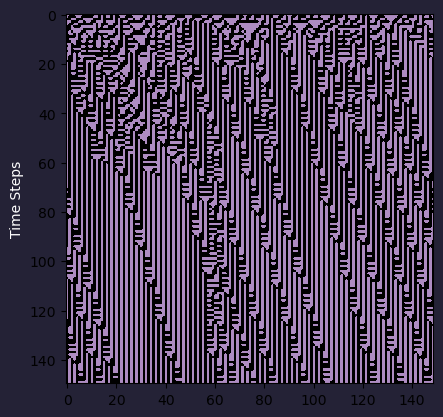

[0.4563758389261745, 0.5100671140939598, 0.5234899328859061, 0.5436241610738255, 0.4563758389261745, 0.5100671140939598, 0.5100671140939598, 0.47651006711409394, 0.5771812080536913, 0.5100671140939598, 0.5234899328859061, 0.5369127516778524, 0.5436241610738255, 0.6040268456375839, 0.5100671140939598, 0.5369127516778524, 0.5369127516778524, 0.5234899328859061, 0.5100671140939598, 0.46308724832214765, 0.5436241610738255, 0.5033557046979866, 0.5302013422818792, 0.5369127516778524, 0.5503355704697986, 0.5302013422818792, 0.5771812080536913, 0.47651006711409394, 0.610738255033557, 0.4563758389261745, 0.5369127516778524, 0.5167785234899329, 0.5302013422818792, 0.5503355704697986, 0.48322147651006714, 0.5234899328859061, 0.5302013422818792, 0.5570469798657718, 0.5234899328859061, 0.5570469798657718, 0.5234899328859061, 0.5436241610738255, 0.5033557046979866, 0.5570469798657718, 0.4697986577181208, 0.5369127516778524, 0.5167785234899329, 0.5503355704697986, 0.5033557046979866, 0.52348993288590

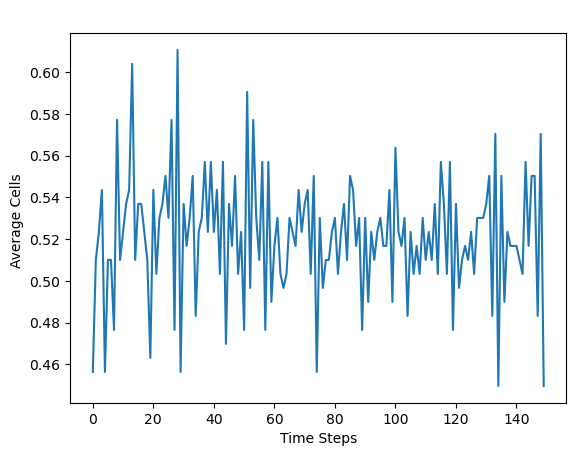

<Figure size 640x480 with 0 Axes>

In [8]:
from CaAttributes import CaNeighbourhoods, MemoryTypes, RuleTypes

%load_ext autoreload
%autoreload 2
from CaMemory1D import CaMemory1D
from ca_funcs import make_glider, make_game_of_life
import tensorflow as tf
import numpy as np
import random
from train_ca import *
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch, logs=None):
        if logs.get('val_accuracy') == 1:
            self.model.stop_training = True 
#Seedings and Config
 

print("Starting...")
SEED =2
random.seed(SEED)
np.random.seed(SEED)
gridsize=149
x_values = [seq for seq in itertools.product("01", repeat=10)]

x_values = [[int(bit) for bit in seq] for seq in x_values]
#x_value = np.random.choice([0, 1], gridsize, p=[.5, .5])

MEMORY_CONSTANT=6
 

 
gol = CaMemory1D(grid_size=gridsize , rule_type=RuleTypes.Default,
                memory_type=MemoryTypes.Most_Frequent, memory_horizon=MEMORY_CONSTANT,initial_state=x_value)


gol.set_rule([[[0, 0, 0],[0, 0, 1],[0, 1, 0],[0, 1, 1],[1, 0, 0],[1, 0, 1],[1, 1, 0],[1, 1, 1]],
              [[0],      [1]         ,[1]      ,[1]     ,[1]      ,[0]      ,[0],     [0 ]]])

gol.step_multiple(149)
gol.render_state()
gol.plot_evolultion()
plt.savefig('rule300.png')

a larger grid allows fore more expressive data

# Visualize Dataset of sequences